In [1]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
import datetime

import numpy as np

In [32]:
# loading dataset
dataframe = pandas.read_csv('../fwddadosdma/41222_DNK_CABIL_CTRLB_FLOW.csv', engine='python', header=0)
dataframe.head()

,dateTime,data
0,2017-12-01 00:00:00,1.92
1,2017-12-01 00:15:00,1.88
2,2017-12-01 00:30:00,1.76
3,2017-12-01 00:45:00,1.39
4,2017-12-01 01:00:00,1.17


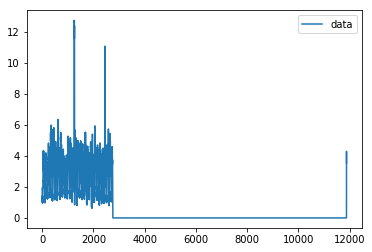

In [33]:
dataframe.plot()

In [34]:
# converting to datetime
dataframe['dateTime']= pandas.to_datetime(dataframe['dateTime'])


In [35]:
dates = dataframe['dateTime']
prev = dates[0]
diffs_counter=dict()

for index in range(1, len(dates)-1):
    diff = dates[index] - prev
    prev = dates[index]
    
    if diff.total_seconds() not in diffs_counter.keys():
        diffs_counter[diff.total_seconds()]=1
    else:
        diffs_counter[diff.total_seconds()]+=1


In [36]:
common_diff = list(diffs_counter)[(np.argmax(diffs_counter))]
prev = dates[0]
time = []
data = []

for index in range(1, len(dates)-1):
    diff = dates[index] - prev
    prev = dates[index]

    
    if not diff.total_seconds() == common_diff:
        total_steps = diff.total_seconds()
        new_data = [[dates[index] - datetime.timedelta(seconds=x),np.nan] for x in range(int(common_diff), int(total_steps),int(common_diff))]
        new_data.reverse()
        for item in new_data:
            time.append(item[0])
            data.append(item[1])
        #nan_data  = [ for x in range(int(common_diff), int(total_steps),int(common_diff))]
        
    time.append(prev)
    data.append(dataframe['data'][index])
        

In [37]:
columns = ['time', 'data']
newDataframe = pandas.DataFrame(columns=columns)

In [38]:
newDataframe.time = time
newDataframe.data = data

In [39]:
newDataframe.set_index('time')
newDataframe.sort_values(by='time')
newDataframe = newDataframe.interpolate()

In [40]:
newDataframe.to_csv('filtered_dataset.csv')